In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from keras_preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import albumentations as A
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import skimage.exposure
import os

In [3]:
from google.colab import drive

drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [4]:
train=pd.read_csv("/content/gdrive/MyDrive/VT Studies/SEM 1/ECE5424_AML/mammography_images/Training_set.csv")
test=pd.read_csv("/content/gdrive/MyDrive/VT Studies/SEM 1/ECE5424_AML/mammography_images/Testing_set.csv")
sub=pd.read_csv("/content/gdrive/MyDrive/VT Studies/SEM 1/ECE5424_AML/mammography_images/sample_submission.csv")

In [5]:
from PIL import Image, ImageEnhance
from numpy import random

# No preprocessing. Just normalizing to pass to CNN
def preprocess(image):
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    im = cv2.filter2D(image, -1, kernel)
    #out2 = skimage.exposure.rescale_intensity(im, in_range=(150,200), out_range=(0,255))
    #print(type(im))
    out1=(cv2.normalize(im, (224,224),0, 255, cv2.NORM_MINMAX))
    #print(type(out1))
    return out1

# Has preprocessing.
def preprocess2(image):
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)
    image = cv2.filter2D(image, -1, kernel)
    out1=(cv2.normalize(image, (224,224),0, 255, cv2.NORM_MINMAX))
    out1 = out1.astype(np.float64)
    return out1

In [6]:
X_train, X_valid = train_test_split(train, test_size=0.1,stratify=train["label"],shuffle=True)

In [7]:
datagen_p1=ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess)

In [8]:
# Creates an iterator for training images
train_generator_p1=datagen_p1.flow_from_dataframe(
dataframe=X_train,
directory="/content/gdrive/MyDrive/VT Studies/SEM 1/ECE5424_AML/mammography_images/train",
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 5151 validated image filenames belonging to 8 classes.


(224, 224, 3)


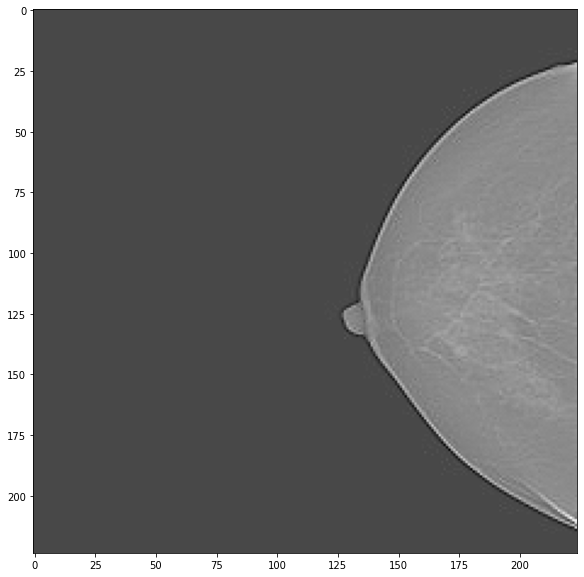

In [9]:
# Showing iteration use to show training mammogram images
x,y = train_generator_p1.next()
for i in range(1):
    image = x[i]
    plt.figure(figsize=(10,10))
    plt.imshow(image.astype('float32'))
    print(image.shape)
    cv2.imwrite("before_pp.jpg", image.astype('float32'))
    #print(y[i])
   
plt.show()

In [ ]:
# Valid data iterator
valid_datagen_p1=ImageDataGenerator(rescale=1./255.,preprocessing_function=preprocess)
valid_generator_p1=valid_datagen_p1.flow_from_dataframe( 
dataframe=X_valid,
directory="/content/gdrive/MyDrive/VT Studies/SEM 1/ECE5424_AML/mammography_images/train",
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 573 validated image filenames belonging to 8 classes.


In [ ]:
# Training data iterator for preprocessed images
datagen_p2=ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess2)
train_generator_p2=datagen_p2.flow_from_dataframe(
dataframe=X_train,
directory="/content/gdrive/MyDrive/VT Studies/SEM 1/ECE5424_AML/mammography_images/train",
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 5151 validated image filenames belonging to 8 classes.


In [ ]:
x,y = train_generator_p2.next()
for i in range(1):
    image = x[i]
    plt.figure(figsize=(10,10))
    plt.imshow(image.astype('float32'))
    print(image.shape)
    cv2.imwrite("after_pp.jpg", image.astype('float32'))
   
plt.show()

In [ ]:
# Valid iterator for preprocessed images
valid_datagen_p2=ImageDataGenerator(rescale=1./255.,preprocessing_function=preprocess2)
valid_generator_p2=valid_datagen_p2.flow_from_dataframe( 
dataframe=X_valid,
directory="/content/gdrive/MyDrive/VT Studies/SEM 1/ECE5424_AML/mammography_images/train",
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 573 validated image filenames belonging to 8 classes.


In [ ]:
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout,AveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3,DenseNet201,EfficientNetB7, MobileNetV2,Xception,VGG16,NASNetMobile
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.models import Sequential
from keras.regularizers import *
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
STEP_SIZE_TRAIN=train_generator_p1.n//train_generator_p1.batch_size
STEP_SIZE_VALID=valid_generator_p1.n//valid_generator_p1.batch_size

In [ ]:
# Training CNN with unprocessed images
model = keras.Sequential([
    keras.layers.Conv2D(32, 3, activation='relu',
                        input_shape=((224,224,3))),
    #keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(8, activation='softmax')
])
 
# Compiling the model
# model.compile(optimizer='adam',
#               loss=keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'])
 
model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001,decay=0.0001),metrics=["accuracy"],loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1))

# Fitting the model with data
model.fit(
        train_generator_p1,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=5,
        validation_data=valid_generator_p1,
        validation_steps=STEP_SIZE_VALID)

In [ ]:
model.evaluate(valid_generator_p1,verbose=1)

In [ ]:
pred1 = model.predict(valid_generator_p1)

In [ ]:
predicted_labels = [np.argmax(i) for i in pred1]
print(len(predicted_labels))

In [ ]:
actual_labels = (np.array(valid_generator_p1.labels))
print(len(actual_labels))

In [ ]:
false_negatives = []

for i in range(len(actual_labels)):
  if predicted_labels[i] != actual_labels[i] and predicted_labels[i]%2==0:
    false_negatives.append(i)

print(false_negatives)

print(predicted_labels[1])

In [ ]:
STEP_SIZE_TRAIN=train_generator_p2.n//train_generator_p2.batch_size
STEP_SIZE_VALID=valid_generator_p2.n//valid_generator_p2.batch_size

In [ ]:
# Training CNN for preprocessed images
model = keras.Sequential([
    keras.layers.Conv2D(32, 3, activation='relu',
                        input_shape=((224,224,3))),
    #keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(8, activation='softmax')
])
 
# Compiling the model
# model.compile(optimizer='adam',
#               loss=keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'])
 
model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001,decay=0.0001),metrics=["accuracy"],loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1))

# Fitting the model with data
history = model.fit(
        train_generator_p2,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=5,
        validation_data=valid_generator_p2,
        validation_steps=STEP_SIZE_VALID)

In [ ]:
# CNN learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(valid_generator_p2,verbose=1)

18/18 [==============================] - 11s 608ms/step - loss: 0.8373 - accuracy: 0.8918


[0.8372977375984192, 0.8917975425720215]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 flatten (Flatten)           (None, 1577088)           0         
                                                                 
 dense (Dense)               (None, 8)                 12616712  
                                                                 
Total params: 12,617,608
Trainable params: 12,617,608
Non-trainable params: 0
_________________________________________________________________


conv2d (3, 3, 3, 32)


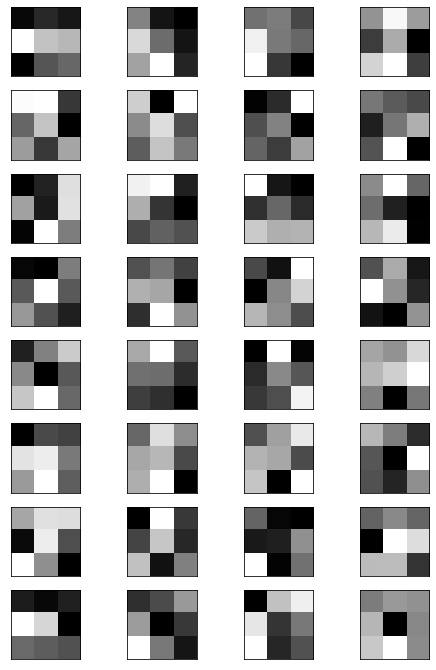

In [ ]:
# Displaying CNN kernels
layer= model.layers
filters, biases= model.layers[0].get_weights()
print(layer[0].name, filters.shape) #filter shape (3, 3, 3, 32) <-- 3 X 3== kernel size, 3== RGB channels, 32== number of filters for that convolutional layer, here layer[0]

fig1=plt.figure(figsize=(8, 12))
columns = 4
rows = 8
n_filters = columns * rows
for i in range(1, n_filters +1):
    f = filters[:, :, :, i-1]
    fig1 =plt.subplot(rows, columns, i)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])
    plt.imshow(f[:, :, 0], cmap='gray') #Show only the filters from 0th channel (R)
    #ix += 1
plt.show()   

In [ ]:
pred1 = model.predict(valid_generator_p2)

18/18 [==============================] - 10s 531ms/step


In [ ]:
predicted_labels = [np.argmax(i) for i in pred1]
print(len(predicted_labels))

573


In [ ]:
actual_labels = (np.array(valid_generator_p2.labels))
print(len(actual_labels))

573


In [ ]:
from sklearn import metrics

print(metrics.confusion_matrix(actual_labels, predicted_labels))

[[ 2 22  3 20  9  3  6  0]
 [18 53  5 47 17 14  7  1]
 [ 2  6  1  9  1  1  2  0]
 [16 68  4 59 12  8  5  1]
 [11 17  3 21  9  4  4  1]
 [ 5 11  2 10  8  5  2  0]
 [ 5 11  0 11  0  5  1  0]
 [ 1  1  0  2  1  0  0  0]]


In [ ]:
false_negatives = []

for i in range(len(actual_labels)):
  if predicted_labels[i] != actual_labels[i] and predicted_labels[i]%2==0:
    false_negatives.append(i)

print(false_negatives)

print(predicted_labels[1])

[3, 4, 10, 23, 26, 27, 28, 33, 35, 36, 41, 47, 62, 64, 68, 69, 71, 74, 75, 78, 80, 89, 94, 99, 101, 102, 106, 107, 127, 132, 134, 137, 141, 147, 151, 154, 155, 158, 167, 168, 177, 178, 188, 191, 192, 203, 205, 206, 208, 214, 235, 238, 241, 244, 252, 254, 276, 283, 287, 289, 293, 295, 297, 298, 303, 306, 312, 313, 315, 318, 319, 324, 325, 326, 330, 332, 335, 337, 339, 349, 352, 353, 354, 358, 359, 360, 363, 364, 365, 366, 367, 374, 380, 383, 391, 400, 403, 404, 410, 411, 413, 415, 417, 422, 426, 431, 433, 434, 437, 441, 446, 447, 452, 453, 456, 457, 465, 472, 474, 475, 476, 479, 480, 481, 482, 487, 492, 493, 498, 499, 503, 506, 507, 508, 515, 516, 526, 528, 529, 538, 549, 554, 559, 567, 568, 572]
3
